# Generalized Regression

In [158]:
from pyspark.sql.functions import col, unix_timestamp
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.types import DoubleType, IntegerType, LongType

In [145]:
# Spark Session
spark = SparkSession.builder \
    .appName("YellowTaxiTripPrediction") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

## Prepare Data

In [146]:
df = spark.read.parquet("../data/processed.parquet")

df.printSchema()

root
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- extras: double (nullable = true)
 |-- PU_Borough: string (nullable = true)
 |-- PU_Zone: string (nullable = true)
 |-- DO_Borough: string (nullable = true)
 |-- DO_Zone: string (nullable = true)



In [147]:
df.show(5)

+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+----------+------------+----+-----------+------+----------+--------------------+----------+--------------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|payment_type|fare_amount|tip_amount|total_amount|hour|day_of_week|extras|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+----------+------------+----+-----------+------+----------+--------------------+----------+--------------------+
|         164|          43|       2| 2024-02-22 19:37:40|  2024-02-22 19:53:42|              6|         2.57|           1|       17.7|      6.05|       30.25|  19|          5|   6.5| Manhattan|        Central Park| Manhattan|       Midtown South|
|         16

In [148]:
# Relevant columns
selected_cols = ["trip_distance", "passenger_count", "PULocationID", "DOLocationID", 
                 "VendorID", "total_amount", "payment_type","hour", "day_of_week"]
df_model = df.select(*selected_cols)

In [149]:
# Train and test split
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)

In [150]:
# Cleaning data
train_data = train_data.na.drop(subset=["trip_distance", "passenger_count", "PULocationID", "DOLocationID", 
                                            "VendorID", "total_amount", "payment_type","hour", "day_of_week"
])

test_data = test_data.na.drop(subset=["trip_distance", "passenger_count", "PULocationID", "DOLocationID", 
                                        "VendorID", "total_amount", "payment_type","hour", "day_of_week"
])

In [ ]:
encoder = OneHotEncoder(
    inputCols=["PULocationID", "DOLocationID", "VendorID", "payment_type"],
    outputCols=["PULocationID_ohe", "DOLocationID_ohe", "VendorID_ohe", "payment_type_ohe"]
)


## Building the Model

In [152]:
feature_cols = [
    "trip_distance", "passenger_count", "hour", "day_of_week",
    "PULocationID_ohe", "DOLocationID_ohe", "VendorID_ohe", "payment_type_ohe"
]

# Assemble features
assembler = VectorAssembler(
    inputCols= feature_cols,
    outputCol="features"
)

# Model creation and training
glr = GeneralizedLinearRegression(
    labelCol="total_amount", 
    featuresCol="features", 
    maxIter=10, 
    regParam=0.1,
    family="gaussian", 
    link="identity"
)

pipeline = Pipeline(stages= [encoder, assembler, glr])
model = pipeline.fit(train_data)

## Model Evaluation

In [153]:
predictions = model.transform(test_data)

# Evaluators and metrics
evaluator_rmse = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 14.81
MAE: 8.37
R²: 0.57


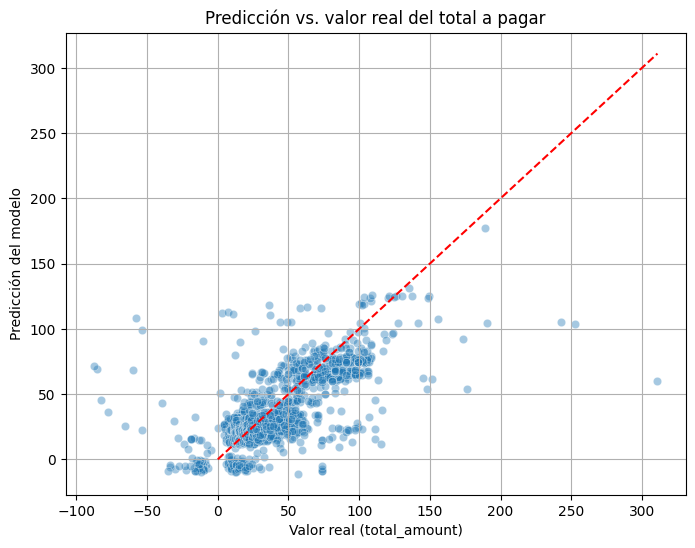

In [154]:
# Convertir a pandas (muestra pequeña)
sample_pd = predictions.select("total_amount", "prediction").dropna().sample(False, 0.01, seed=42).toPandas()

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(x="total_amount", y="prediction", data=sample_pd, alpha=0.4)
plt.plot([0, sample_pd["total_amount"].max()], [0, sample_pd["total_amount"].max()], color="red", linestyle="--")
plt.xlabel("Valor real (total_amount)")
plt.ylabel("Predicción del modelo")
plt.title("Predicción vs. valor real del total a pagar")
plt.grid(True)
plt.show()


Although the fare calculation is linear in theory, the available input features (especially categorical zones and context factors) involve complex, non-linear interactions that a simple GLR cannot model effectively.

# Predicting Trip Distance

In [161]:
df.show(5)

+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+----------+------------+----+-----------+------+----------+--------------------+----------+--------------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|payment_type|fare_amount|tip_amount|total_amount|hour|day_of_week|extras|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+----------+------------+----+-----------+------+----------+--------------------+----------+--------------------+
|         164|          43|       2| 2024-02-22 19:37:40|  2024-02-22 19:53:42|              6|         2.57|           1|       17.7|      6.05|       30.25|  19|          5|   6.5| Manhattan|        Central Park| Manhattan|       Midtown South|
|         16

In [162]:
# Select just numerical columns
numerical_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, LongType, DoubleType))]

distance_model_df = df.select(*numerical_cols)

In [163]:
# Train and test split
train_data, test_data = distance_model_df.randomSplit([0.8, 0.2], seed=42)

In [164]:
# Cleaning data
train_data = train_data.na.drop(subset=["trip_distance", "passenger_count", "PULocationID", "DOLocationID", 
                                            "VendorID", "total_amount", "payment_type","hour", "day_of_week"
])

test_data = test_data.na.drop(subset=["trip_distance", "passenger_count", "PULocationID", "DOLocationID", 
                                        "VendorID", "total_amount", "payment_type","hour", "day_of_week"
])

In [165]:
encoder = OneHotEncoder(
    inputCols=["PULocationID", "DOLocationID", "VendorID", "payment_type"],
    outputCols=["PULocationID_ohe", "DOLocationID_ohe", "VendorID_ohe", "payment_type_ohe"]
)

In [166]:
# Feature columns
feature_cols = [col for col in numerical_cols if col != "trip_distance"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Model creation and training
glr = GeneralizedLinearRegression(
    labelCol="trip_distance", 
    featuresCol="features", 
    maxIter=10, 
    regParam=0.1,
    family="gaussian", 
    link="identity"
)

pipeline = Pipeline(stages= [encoder, assembler, glr])
model = pipeline.fit(train_data)

In [167]:
predictions = model.transform(test_data)

# Evaluators and metrics
evaluator_rmse = RegressionEvaluator(labelCol="trip_distance", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="trip_distance", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="trip_distance", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 111.54
MAE: 1.22
R²: 0.00


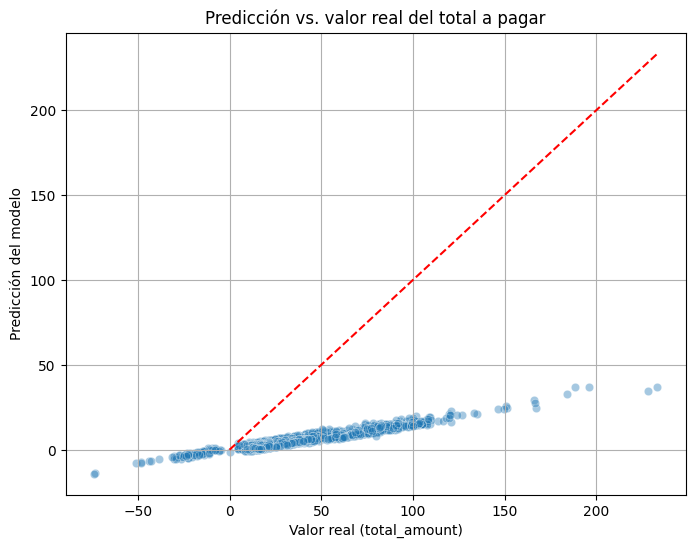

In [168]:
# Convertir a pandas (muestra pequeña)
sample_pd = predictions.select("total_amount", "prediction").dropna().sample(False, 0.01, seed=42).toPandas()

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(x="total_amount", y="prediction", data=sample_pd, alpha=0.4)
plt.plot([0, sample_pd["total_amount"].max()], [0, sample_pd["total_amount"].max()], color="red", linestyle="--")
plt.xlabel("Valor real (total_amount)")
plt.ylabel("Predicción del modelo")
plt.title("Predicción vs. valor real del total a pagar")
plt.grid(True)
plt.show()
